In [328]:
# PACKAGES
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.model_selection import TimeSeriesSplit

In [329]:
def comp_vol(x):
    return np.sqrt(np.sum(x**2))

stock = read_and_preprocess_stock(f"individual_book_train/stock_1.csv")
unique_time_id = stock['time_id'].unique()

stock['WAP'] = (stock['bid_price1'] * stock['ask_size1'] + stock['ask_price1'] * stock['bid_size1']) / (stock['bid_size1'] + stock['ask_size1'])
stock['BidAskSpread'] = (stock['ask_price1'] / stock['bid_price1']) - 1

log_r1 = []

for time_id in unique_time_id:
    data = stock[stock['time_id'] == time_id]
    sec = data['seconds_in_bucket'].values
    price = data['WAP'].values
    log_r = np.log(price[1:] / price[:-1])
    log_returns_df = pd.DataFrame({'time': sec[1:], 'log_return': log_r})
    time_no_change = np.setdiff1d(np.arange(1, 601), log_returns_df['time'])
    if len(time_no_change) > 0:
        new_df = pd.DataFrame({'time': time_no_change, 'log_return': [0] * len(time_no_change)})
        log_returns_df = pd.concat([log_returns_df, new_df])
        log_returns_df = log_returns_df.sort_values('time')
    log_r1.append(log_returns_df)

vol = []

for df in log_r1:
    df['time_bucket'] = np.ceil(df['time'] / 30).astype(int)
    grouped = df.groupby('time_bucket')['log_return'].agg(comp_vol).reset_index()
    grouped.columns = ['time_bucket', 'volatility']
    vol.append(grouped)
    
vol[0]

,time_bucket,volatility
0,1,0.001703
1,2,0.000853
2,3,0.001814
3,4,0.000978
4,5,0.001890
5,6,0.001124
6,7,0.001322
7,8,0.001671
8,9,0.001796
9,10,0.001412


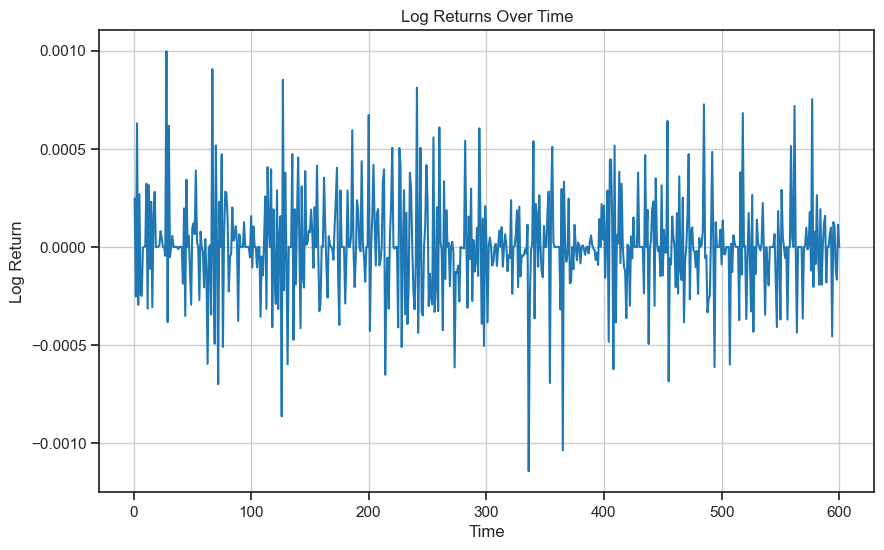

In [330]:
# Assuming df is a pandas DataFrame with 'time' and 'log_return' columns
df = log_r1[0]  # If you want to plot the first DataFrame from your list

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df['time'], df['log_return'], linestyle='-')  # Line plot
plt.title('Log Returns Over Time')  # Add a title
plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Log Return')  # Label for the y-axis
plt.grid(True)  # Add a grid for easier readability
plt.show()  # Display the plot

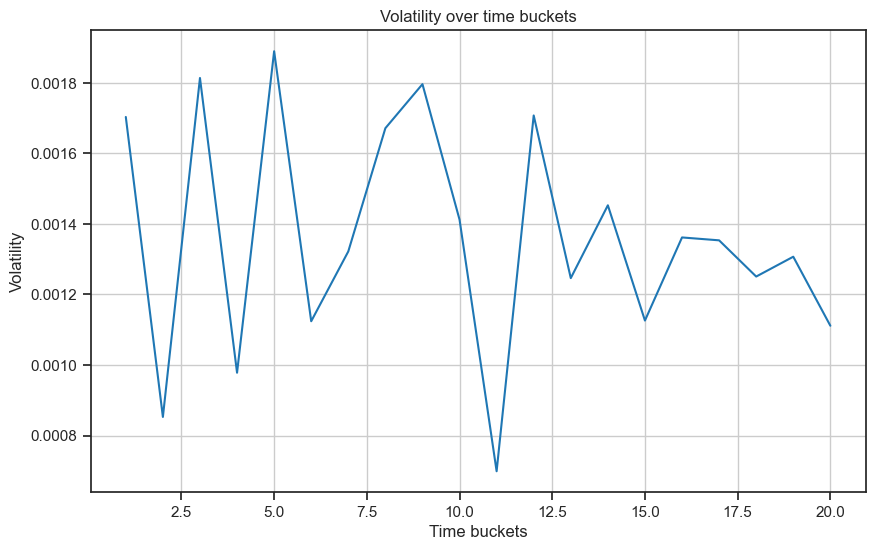

In [331]:
# Assuming df is a pandas DataFrame with 'time' and 'log_return' columns
df = vol[0]  # If you want to plot the first DataFrame from your list

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df['time_bucket'], df['volatility'], linestyle='-')  # Line plot
plt.title('Volatility over time buckets')  # Add a title
plt.xlabel('Time buckets')  # Label for the x-axis
plt.ylabel('Volatility')  # Label for the y-axis
plt.grid(True)  # Add a grid for easier readability
plt.show()  # Display the plot

**WINTERHOLT EXPONENTIAL SMOOTHING**

0    0.001703
1    0.000853
2    0.001814
3    0.000978
4    0.001890
Name: volatility, dtype: float64


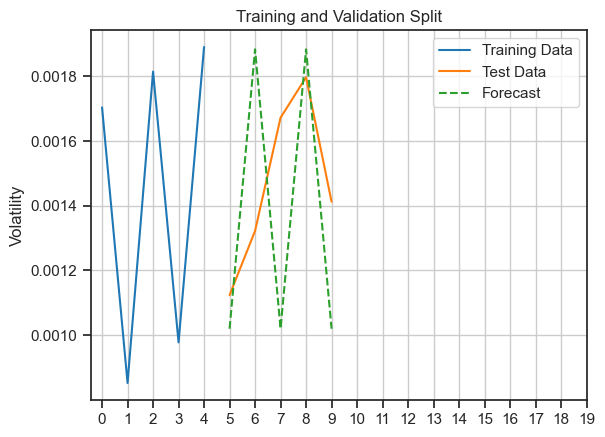

0    0.001703
1    0.000853
2    0.001814
3    0.000978
4    0.001890
5    0.001124
6    0.001322
7    0.001671
8    0.001796
9    0.001412
Name: volatility, dtype: float64


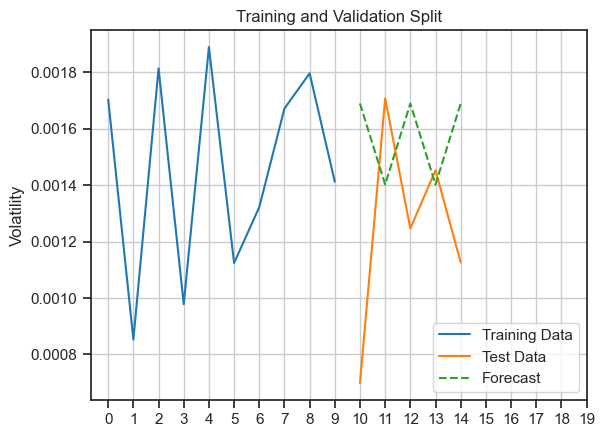

0     0.001703
1     0.000853
2     0.001814
3     0.000978
4     0.001890
5     0.001124
6     0.001322
7     0.001671
8     0.001796
9     0.001412
10    0.000699
11    0.001708
12    0.001246
13    0.001453
14    0.001126
Name: volatility, dtype: float64


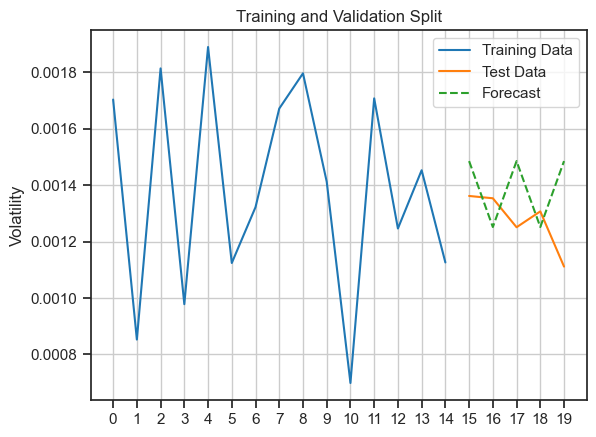

Average MSE: 1.8165640917034907e-07
Average MAPE: 29.677837833153145


In [332]:
# FOLLOW THIS!!! TIME-SERIES CROSS VALIDATION METHOD
train_ratio = 0.8
split_point = int(len(vol_5) * train_ratio)
train_data = vol_5[:split_point]
validation_data = vol_5[split_point:]

tscv = TimeSeriesSplit(n_splits = 3)
mse_scores = []
mape_scores = []

for train_index, test_index in tscv.split(vol_5):
    print(vol_5[train_index])
    train_data, test_data = vol_5[train_index], vol_5[test_index]
    model = ExponentialSmoothing(train_data, seasonal = 'add', seasonal_periods = 2)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=len(test_data))
    
    # METRICS
    mse = ((forecast - test_data) ** 2).mean()
    mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
    mse_scores.append(mse)
    mape_scores.append(mape)

    # VISUALISATIONS
    plt.plot(train_index, train_data, label = 'Training Data')
    plt.plot(test_index, test_data, label = 'Test Data')
    plt.plot(test_index, forecast, label = 'Forecast', linestyle='--')
    plt.title('Training and Validation Split')
    plt.ylabel('Volatility')
    plt.xticks(np.arange(min(vol_5.index), max(vol_5.index)+1, 1))
    plt.grid(True)
    plt.legend()
    plt.show()

print("Average MSE:", np.mean(mse_scores))
print("Average MAPE:", np.mean(mape_scores))

In [357]:
# TRIAL ALL TOGETHER
selected_stocks = [46, 43, 41, 29, 125, 27, 97, 75, 18, 80]
selected_time_ids = [21169, 16992, 22964, 18029, 3622, 15883, 28292, 29380, 24600, 18656]
selected_vols = {}

for i in selected_stocks:
    stock = pd.read_csv(f"individual_book_train/stock_{i}.csv")

    stock['WAP'] = (stock['bid_price1'] * stock['ask_size1'] + stock['ask_price1'] * stock['bid_size1']) / (stock['bid_size1'] + stock['ask_size1'])
    stock['BidAskSpread'] = (stock['ask_price1'] / stock['bid_price1']) - 1

    df = []

    for time_id in selected_time_ids:
        data = stock[stock['time_id'] == time_id]
        sec = data['seconds_in_bucket'].values
        price = data['WAP'].values
        log_r = np.log(price[1:] / price[:-1])
        log_returns_df = pd.DataFrame({'time': sec[1:], 'log_return': log_r})
        time_no_change = np.setdiff1d(np.arange(1, 601), log_returns_df['time'])
        if len(time_no_change) > 0:
            new_df = pd.DataFrame({'time': time_no_change, 'log_return': [0] * len(time_no_change)})
            log_returns_df = pd.concat([log_returns_df, new_df])
            log_returns_df = log_returns_df.sort_values('time')
        df = log_returns_df
        
        df['time_bucket'] = np.ceil(df['time'] / 30).astype(int)
        grouped = df.groupby('time_bucket')['log_return'].agg(comp_vol).reset_index()
        grouped.columns = ['time_bucket', 'volatility']
        selected_vols[f's{i}_t{time_id}'] =  grouped

In [351]:
# CV METHOD
keys = list(selected_vols.keys())
mse_vals = []
mape_vals = []

for key in keys:
    vol = selected_vols[key]['volatility']
    train_ratio = 0.8
    split_point = int(len(vol) * train_ratio)
    train_data = vol[:split_point]
    validation_data = vol[split_point:]
    
    for train_index, test_index in tscv.split(vol):
        tscv = TimeSeriesSplit(n_splits = 3)
        train_data, test_data = vol[train_index], vol[test_index]
        model = ExponentialSmoothing(train_data, seasonal = 'add', seasonal_periods = 2)
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test_data))

        # METRICS
        mse = ((forecast - test_data) ** 2).mean()
        mask = test_data != 0
        mape = np.mean(np.abs((test_data[mask] - forecast[mask]) / test_data[mask])) * 100
        mse_vals.append(mse)
        mape_vals.append(mape)
        
print(f'WinterHolt Model\'s MSE: {np.mean(mse_vals)}')
print(f'WinterHolt Model\'s MAPE: {np.mean(mape_vals)}')

WinterHolt Model's MSE: 2.0557322207512827e-06
WinterHolt Model's MAPE: 1253.5537871818121


In [356]:
# ROLLING WINDOW
mse_vals = []
mape_vals = []

for key in keys:
    vol = selected_vols[key]['volatility']
    window_size = 12
    forecast_horizon = 5
    rolling_starts = range(len(vol) - window_size - forecast_horizon + 1)

    for start in rolling_starts:
        end = start + window_size
        train_data = vol[start:end]
        test_data = vol[end:end+forecast_horizon]
        model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=4)
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=forecast_horizon)

        # METRICS
        mse = ((forecast - test_data) ** 2).mean()
        mask = test_data != 0
        mape = np.mean(np.abs((test_data[mask] - forecast[mask]) / test_data[mask])) * 100
        mse_vals.append(mse)
        mape_vals.append(mape)

#         # VISUALISATION
#         plt.figure(figsize = (10, 4))
#         plt.plot(train_data.index, train_data, label='Training Data')
#         plt.plot(test_data.index, test_data, label='Test Data')
#         plt.plot(test_data.index, forecast, label='Forecast', linestyle='--')
#         plt.title(f'Training and Validation Split from {start} to {end+forecast_horizon}')
#         plt.legend()
#         plt.show()

print(f'WinterHolt Model\'s MSE: {np.mean(mse_vals)}')
print(f'WinterHolt Model\'s MAPE: {np.mean(mape_vals)}')

WinterHolt Model's MSE: 2.5071387088154512e-06
WinterHolt Model's MAPE: 653.2460517439137


**SIMPLE EXPONENTIAL SMOOTHING**

Mean Squared Error (MSE): 1.7858730344170793e-08
Mean Absolute Percentage Error (MAPE): 97.62337764796895
Akaike Information Criterion (AIC): -248.09681319263234
Bayesian Information Criterion (BIC): -246.5516357481528


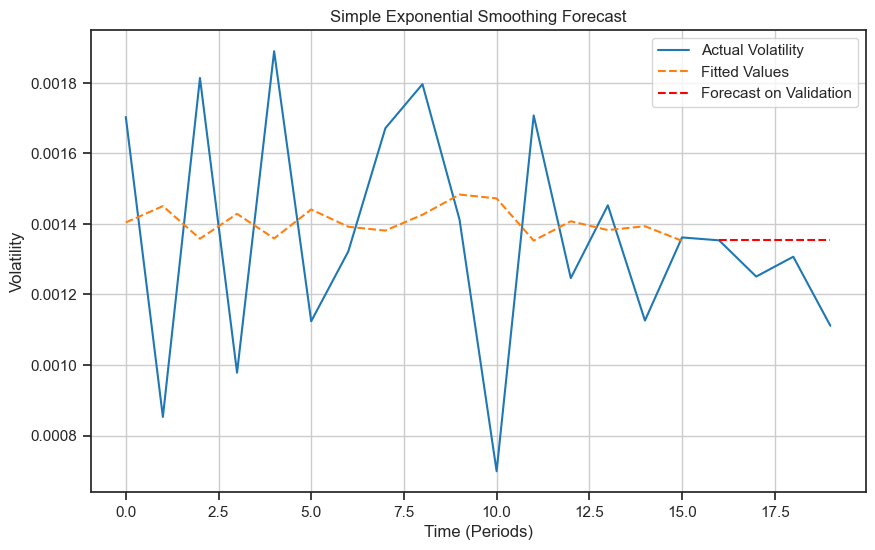

In [154]:
model = SimpleExpSmoothing(train_data)
fitted_model = model.fit()
forecast = fitted_model.forecast(steps=len(validation_data))

# METRICS
mse = ((forecast - validation_data) ** 2).mean()
mape = np.mean(np.abs((data_series - fitted_model.fittedvalues) / data_series)) * 100
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", fitted_model.aic)
print("Bayesian Information Criterion (BIC):", fitted_model.bic)

# VISUALISATION
plt.figure(figsize=(10, 6))
plt.plot(vol_5.index, vol_5, label='Actual Volatility')
plt.plot(train_data.index, fitted_model.fittedvalues, label='Fitted Values', linestyle='--')
plt.plot(validation_data.index, forecast, label='Forecast on Validation', color='red', linestyle='--')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Time (Periods)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

**HOLT'S EXPONENTIAL SMOOTHING**

Mean Squared Error (MSE): 1.2514966546996316e-06
Mean Absolute Percentage Error (MAPE): 5676.238572076326
Akaike Information Criterion (AIC): -215.97921369693404
Bayesian Information Criterion (BIC): -213.1470128925252


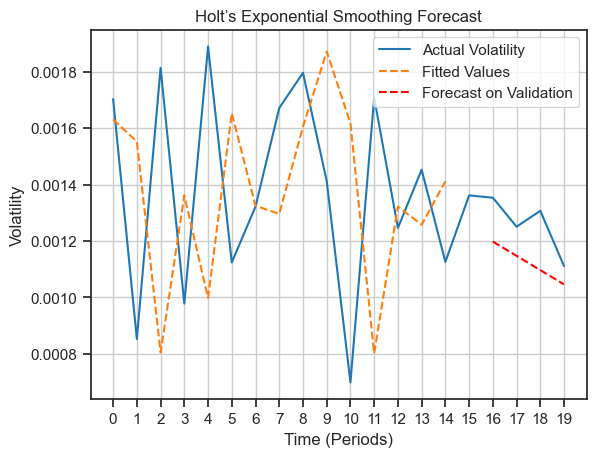

In [186]:
model = Holt(train_data)
fitted_model = model.fit(optimized = True)
forecast = fitted_model.forecast(steps = len(validation_data))


# METRICS
mse = ((forecast - validation_data) ** 2).mean()
mape = np.mean(np.abs((validation_data - forecast) / validation_data)) * 100
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", fitted_model.aic)
print("Bayesian Information Criterion (BIC):", fitted_model.bic)

# VISUALISATION
plt.plot(vol_5.index, vol_5, label='Actual Volatility')
plt.plot(train_data.index, fitted_model.fittedvalues, label='Fitted Values', linestyle='--')
plt.plot(validation_data.index, forecast, label='Forecast on Validation', color='red', linestyle='--')
plt.title('Holt’s Exponential Smoothing Forecast')
plt.xlabel('Time (Periods)')
plt.xticks(np.arange(min(vol_5.index), max(vol_5.index)+1, 1))
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

**ARIMA**

In [157]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print("The series is stationary.")
        return True
    else:
        print("The series is not stationary.")
        return False

ADF Statistic: -0.813313
p-value: 0.815180
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
The series is not stationary. Consider differencing the data.
Mean Squared Error (MSE): 1.141781249274268e-08
Mean Absolute Percentage Error (MAPE): 7.009760735417098
Akaike Information Criterion (AIC): -187.48191392688852
Bayesian Information Criterion (BIC): -185.3577633235819


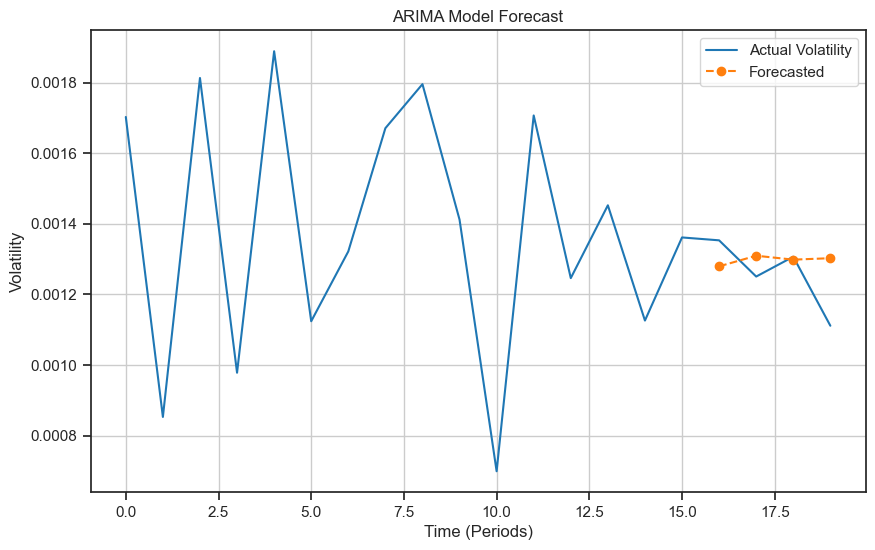

In [158]:
# Check if data is stationary
result = adfuller(vol_5)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation based on ADF test
if result[0] < result[4]["5%"]:
    print("The series is stationary.")
else:
    print("The series is not stationary. Consider differencing the data.")

# Fit the ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))  # Example order, adjust based on your data analysis
fitted_model = model.fit()

# Forecast the validation period
forecast = fitted_model.forecast(steps=len(validation_data))

# Calculate MSE and MAPE
mse = ((forecast - validation_data) ** 2).mean()
mape = np.mean(np.abs((validation_data - forecast) / validation_data)) * 100

# Output MSE and MAPE
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", fitted_model.aic)
print("Bayesian Information Criterion (BIC):", fitted_model.bic)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(vol_5.index, vol_5, label='Actual Volatility')
plt.plot(range(split_point, len(vol_5)), forecast, label='Forecasted', marker='o', linestyle='--')
plt.title('ARIMA Model Forecast')
plt.xlabel('Time (Periods)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

**ARMA/ARIMA**

ADF Statistic: -0.813313
p-value: 0.815180
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
The series is not stationary.

Data after first differencing:
ADF Statistic: -4.300828
p-value: 0.000443
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
The series is stationary.

Mean Squared Error (MSE): 3.7695338296745985e-09
Mean Absolute Percentage Error (MAPE): 220.40326296734554
Akaike Information Criterion (AIC): -185.39015219983827
Bayesian Information Criterion (BIC): -182.55795139542943


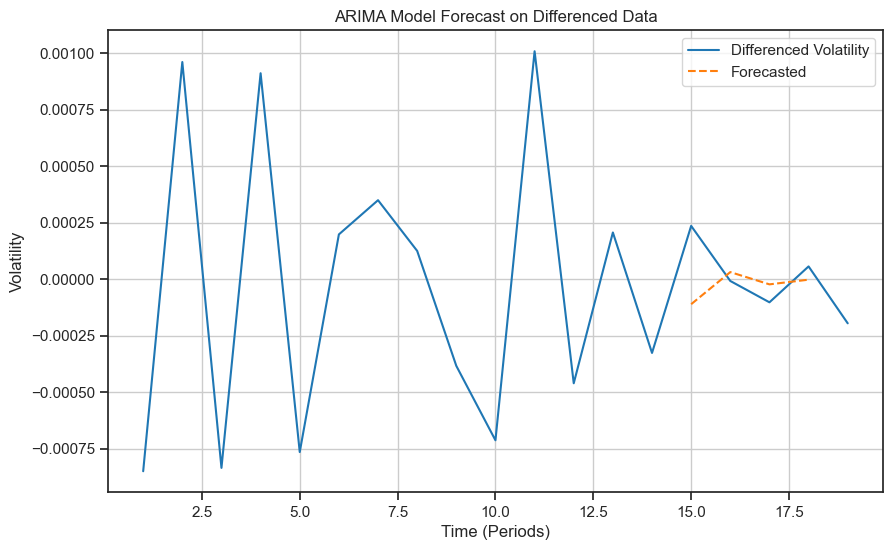

In [159]:
vol_5_s = vol[0]['volatility']
# Check stationarity
stationary = adf_test(vol_5)
print()

# Differencing the data if not stationary
if not stationary:
    vol_5_s = vol_5.diff().dropna()
    print("Data after first differencing:")
    adf_test(vol_5_s)
    print()
    
train_ratio = 0.8
split_point = int(len(vol_5_s) * train_ratio)
train_data = vol_5_s[:split_point]
validation_data = vol_5_s[split_point:]

# Fit the ARIMA model
model = ARIMA(train_data, order=(1, 0, 1))  # Adjusted order after differencing
fitted_model = model.fit()

# Forecast the validation period
forecast = fitted_model.forecast(steps=len(validation_data))

# Calculate MSE and MAPE
mse = ((forecast - validation_data) ** 2).mean()
mape = np.mean(np.abs((validation_data - forecast) / validation_data)) * 100

# Output MSE and MAPE
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", fitted_model.aic)
print("Bayesian Information Criterion (BIC):", fitted_model.bic)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(vol_5_s.index, vol_5_s, label='Differenced Volatility')
plt.plot(range(split_point, len(vol_5_s)), forecast, label='Forecasted', linestyle='--')
plt.title('ARIMA Model Forecast on Differenced Data')
plt.xlabel('Time (Periods)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

**Autoregressive AR-X(p) model**

ADF Statistic: -0.813313
p-value: 0.815180
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
The series is not stationary.

Data after first differencing:
ADF Statistic: -4.300828
p-value: 0.000443
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
The series is stationary.

ADF Statistic: -4.300828274264063
p-value: 0.0004427475659078233
The series is stationary.
Mean Squared Error (MSE): 1.173085609120553e-08
Mean Absolute Percentage Error (MAPE): 251.22847339915725
Akaike Information Criterion (AIC): -159.5147654934746
Bayesian Information Criterion (BIC): -157.25496806362847


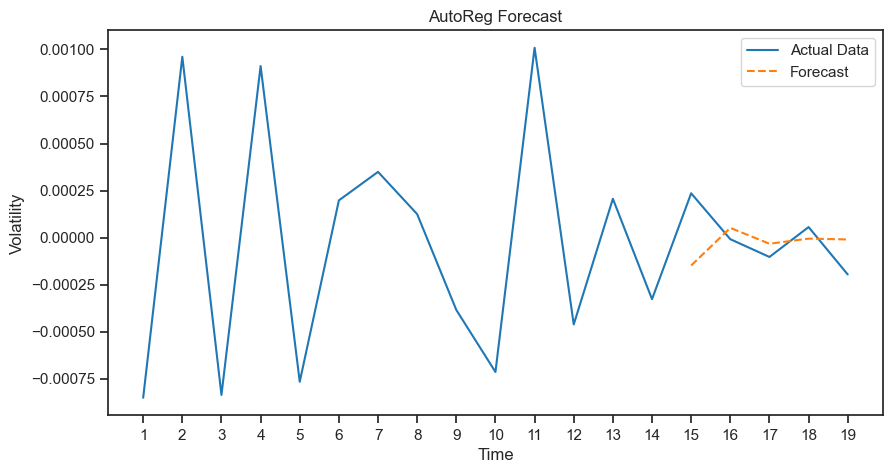

In [169]:
vol_5_s = vol[0]['volatility']
# Check stationarity
stationary = adf_test(vol_5)
print()

# Differencing the data if not stationary
if not stationary:
    vol_5_s = vol_5.diff().dropna()
    print("Data after first differencing:")
    adf_test(vol_5_s)
    print()
    
train_ratio = 0.8
split_point = int(len(vol_5_s) * train_ratio)
train_data = vol_5_s[:split_point]
validation_data = vol_5_s[split_point:]

# Ensure data is stationary
result = adfuller(vol_5_s)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[0] < result[4]['5%']:
    print("The series is stationary.")
else:
    print("The series is not stationary. Consider differencing the data.")

# Split the data into training and testing sets
split_point = int(len(vol_5_s) * 0.8)
train_data = vol_5_s[:split_point]
test_data = vol_5_s[split_point:]

# Fit the AutoReg model
model = AutoReg(train_data, lags=2)  # Change the number of lags as necessary
fitted_model = model.fit()

# Forecasting
forecast = fitted_model.predict(start=len(train_data), end=len(vol_5_s), dynamic=False)

# Calculate MSE and MAPE
mse = ((forecast - validation_data) ** 2).mean()
mape = np.mean(np.abs((validation_data - forecast) / validation_data)) * 100

# Output MSE and MAPE
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", fitted_model.aic)
print("Bayesian Information Criterion (BIC):", fitted_model.bic)

# Plotting the forecasts against actual outcomes
plt.figure(figsize=(10, 5))
plt.plot(vol_5_s, label='Actual Data')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title('AutoReg Forecast')
plt.xlabel('Time')
plt.xticks(np.arange(min(vol_5_s.index), max(vol_5_s.index)+1, 1))
plt.ylabel('Volatility')
plt.legend()
plt.show()

**THETA MODEL**

In [173]:
# Initialize and fit the ThetaModel on the training data
model = ThetaModel(train_data)
fitted_model = model.fit()

# Forecasting the validation period
forecast = fitted_model.forecast(steps=len(validation_data))

# Calculate MSE and MAPE
mse = ((forecast - validation_data) ** 2).mean()
mape = np.mean(np.abs((validation_data - forecast) / validation_data)) * 100

# Output MSE and MAPE
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data_series.index, data_series, label='Actual Volatility', marker='o')
plt.plot(validation_data.index, forecast, label='Forecast', linestyle='--', color='red')
plt.title('Theta Model Forecast Evaluation')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

ValueError: You must specify a period or endog must be a pandas object with a DatetimeIndex with a freq not set to None

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

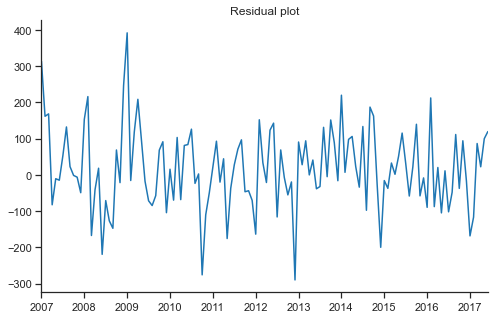

In [25]:
resid = (y-mhw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

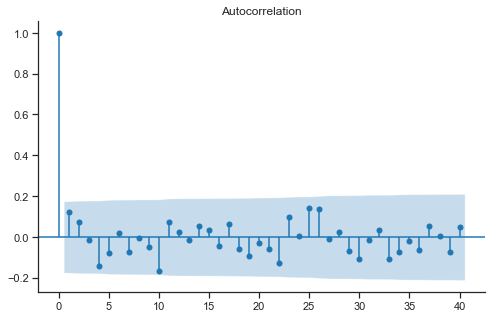

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

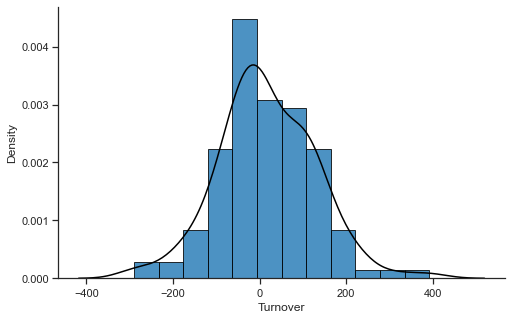

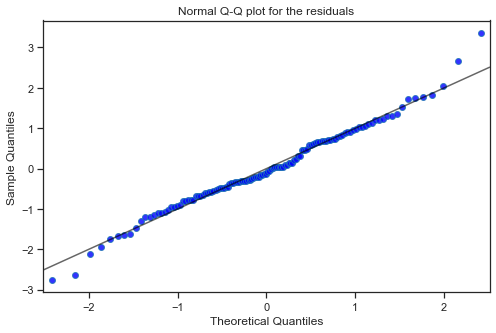

In [27]:
from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

In [28]:
print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

Residual skewness: 0.163
Residual kurtosis: 0.788


## Model validation

The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

In [29]:
# Real time forecasting 

ts=np.log(y) # log series for the log-additive model

validation=y['2012-01':].index
start = y.index.get_loc('2012-01') 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    resid = (ts.iloc[:i]-model.smooth())[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [30]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,385.73,21.12
Additive,146.49,17.78
Multiplicative,134.39,10.07
Log additive,129.95,10.75


## Forecast

Finally, we generate a two year forecast based on the selected model. 

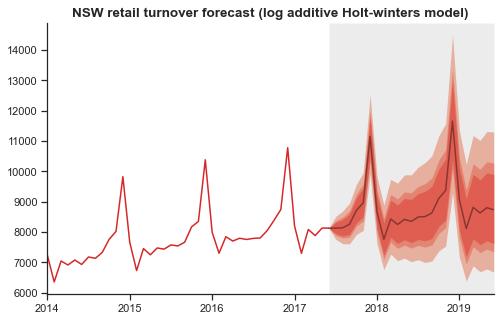

In [31]:
h=24

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred=pd.Series(ahw_log.forecast(h), index=test)
var = ahw_log.forecastvariance(h)
pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(ahw_log.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(ahw_log.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(ahw_log.intervalforecast(h, level=.99), index=test)
intv1=np.exp(intv1)
intv2=np.exp(intv2)
intv3=np.exp(intv3)

fig, ax = forecast.fanchart(y['01-2014':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('NSW retail turnover forecast (log additive Holt-winters model)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()